PLot code bo vae v BO vae sdr v BO

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, RBF
from scipy.stats import norm, qmc

import matplotlib.pyplot as plt

###############################################################################
#                         experiment configuration                            #
###############################################################################

FUNC_NAME   = "Ackley_f"    # "Ackley_f", "Rosenbrock_f", "Rastrigin_f", "Levy_f", "1_norm"
DIM_X       = 20            # input dimension
LATENT_DIM  = 5             # latent dimension for VAE
N_DATA      = 10000         # training samples for VAE

N_INIT_BO   = 40            # initial design size for BO
N_ITER_BO   = 100           # BO iterations
N_CAND      = 512           # Sobol candidates per BO step

N_RUNS      = 5             # repetitions for each BO variant

SEED_TRAIN  = 123           # seed for VAE training and data
BASE_SEED_BO = 1000         # base seed for BO runs

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

###############################################################################
#                           test function                                     #
###############################################################################

class TestFunction:
    def __init__(self, func_type, n_x, bounds=None, x_shift=None, track_x=False):
        self.func_type = func_type
        self.n_x       = n_x
        self.track_x   = track_x

        if bounds is not None:
            self.lb = bounds[:, 0]
            self.ub = bounds[:, 1]
        else:
            self.lb = np.zeros(n_x)
            self.ub = np.ones(n_x)

        if x_shift is not None:
            self.x_shift = x_shift
        else:
            self.x_shift = np.zeros((n_x, 1))

        self.f_list = []
        self.x_list = []

    def eval(self, x):
        x_arr = np.array(x, dtype=float).reshape((self.n_x, 1)) + self.x_shift

        if self.func_type == "Rosenbrock_f":
            val = ((1.0 - x_arr) ** 2).sum() + 100.0 * ((x_arr[1:] - x_arr[:-1] ** 2) ** 2).sum()

        elif self.func_type == "Levy_f":
            w = 1.0 + (x_arr - 1.0) / 4.0
            term1 = np.sin(np.pi * w[0]) ** 2
            term2 = ((w[:-1] - 1.0) ** 2 * (1.0 + 10.0 * np.sin(np.pi * w[:-1] + 1.0) ** 2)).sum()
            term3 = (w[-1] - 1.0) ** 2 * (1.0 + np.sin(2.0 * np.pi * w[-1]) ** 2)
            val = float(term1 + term2 + term3)

        elif self.func_type == "Rastrigin_f":
            val = 10.0 * self.n_x + (x_arr ** 2 - 10.0 * np.cos(2.0 * np.pi * x_arr)).sum()
            val = float(val)

        elif self.func_type == "Ackley_f":
            a, b, c = 20.0, 0.2, 2.0 * np.pi
            norm_sq = (x_arr ** 2).sum()
            term1 = -a * np.exp(-b * np.sqrt(norm_sq / self.n_x))
            term2 = -np.exp(np.cos(c * x_arr).sum() / self.n_x)
            val = float(term1 + term2 + a + np.e)

        elif self.func_type == "1_norm":
            val = float(np.abs(x_arr).sum())

        else:
            raise ValueError(f"Unsupported function type {self.func_type}")

        self.f_list.append(val)
        if self.track_x:
            self.x_list.append(x_arr.copy())
        return val

# global bounds in input space
bounds_x = np.array([[-5.0, 5.0]] * DIM_X)
t_func = TestFunction(FUNC_NAME, DIM_X, bounds=bounds_x)

###############################################################################
#                         data for VAE training                               #
###############################################################################

np.random.seed(SEED_TRAIN)
torch.manual_seed(SEED_TRAIN)

U = np.random.rand(N_DATA, DIM_X)
X = t_func.lb + U * (t_func.ub - t_func.lb)
X = X.astype(np.float32)

###############################################################################
#                           VAE model                                         #
###############################################################################

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, mean_decoder=False):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 128), nn.SiLU(),
            nn.Linear(128, 64), nn.SiLU(),
            nn.Linear(64, 32), nn.SiLU(),
        )
        self.mu     = nn.Linear(32, latent_dim)
        self.logvar = nn.Linear(32, latent_dim)

        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 32), nn.SiLU(),
            nn.Linear(32, 64), nn.SiLU(),
            nn.Linear(64, 128), nn.SiLU(),
            nn.Linear(128, input_dim),
        )
        self.mean_decoder = mean_decoder

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h  = self.enc(x)
        mu = self.mu(h)
        lv = self.logvar(h)

        if self.mean_decoder:
            z = mu
        else:
            z = self.reparam(mu, lv)

        xhat = self.dec(z)
        return xhat, mu, lv, z

    @torch.no_grad()
    def encode_mu(self, x):
        h = self.enc(x)
        return self.mu(h)

    @torch.no_grad()
    def decode(self, z):
        return self.dec(z)

def train_vae(
    X_full,
    latent_dim,
    lr=1.5e-3,
    batch_size=128,
    max_epochs=600,
    patience=80,
    beta_start=0.0,
    beta_inc=0.001,
    beta_max=0.05,
    beta_freeze_epochs=100,
    log_every=20,
):
    X_full = np.asarray(X_full, dtype=np.float32)
    N, D = X_full.shape

    idx = np.random.permutation(N)
    split = int(0.8 * N)
    tr_idx, va_idx = idx[:split], idx[split:]

    Xtr_raw, Xva_raw = X_full[tr_idx], X_full[va_idx]

    mu  = Xtr_raw.mean(axis=0, keepdims=True).astype(np.float32)
    std = (Xtr_raw.std(axis=0, keepdims=True) + 1e-8).astype(np.float32)

    Xtr = (Xtr_raw - mu) / std
    Xva = (Xva_raw - mu) / std

    Xtr = np.ascontiguousarray(Xtr, dtype=np.float32)
    Xva = np.ascontiguousarray(Xva, dtype=np.float32)

    train_loader = DataLoader(
        TensorDataset(torch.from_numpy(Xtr), torch.from_numpy(Xtr)),
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
    )
    val_loader = DataLoader(
        TensorDataset(torch.from_numpy(Xva), torch.from_numpy(Xva)),
        batch_size=256,
        shuffle=False,
        drop_last=False,
    )

    model = VAE(input_dim=D, latent_dim=latent_dim, mean_decoder=False).to(DEVICE)

    opt   = Adam(model.parameters(), lr=lr)
    sched = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=20, min_lr=1e-6)
    mse   = nn.MSELoss(reduction="mean")

    train_hist, val_hist, beta_hist, kl_hist = [], [], [], []
    best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    best_val_recon = np.inf
    no_imp = 0
    beta = beta_start

    for epoch in range(1, max_epochs + 1):
        if epoch <= beta_freeze_epochs:
            beta_eff = 0.0
        else:
            beta = min(beta + beta_inc, beta_max)
            beta_eff = beta

        model.train()
        tr_sum = 0.0
        kl_sum = 0.0
        n_tr = 0

        for xb, _ in train_loader:
            xb = xb.to(DEVICE)
            opt.zero_grad()
            xhat, mu_t, lv_t, _ = model(xb)
            recon = mse(xhat, xb)
            kl = -0.5 * torch.mean(torch.sum(1 + lv_t - mu_t.pow(2) - lv_t.exp(), dim=1))
            loss = recon + beta_eff * kl
            loss.backward()
            opt.step()

            tr_sum += loss.item() * xb.size(0)
            kl_sum += kl.item() * xb.size(0)
            n_tr   += xb.size(0)

        tr_loss = tr_sum / n_tr
        kl_avg  = kl_sum / n_tr

        model.eval()
        rec_sum = 0.0
        n_va = 0
        with torch.no_grad():
            for xb, _ in val_loader:
                xb = xb.to(DEVICE)
                xhat, mu_t, lv_t, _ = model(xb)
                recon = mse(xhat, xb)
                rec_sum += recon.item() * xb.size(0)
                n_va   += xb.size(0)
        val_recon = rec_sum / n_va

        train_hist.append(tr_loss)
        val_hist.append(val_recon)
        beta_hist.append(beta_eff)
        kl_hist.append(kl_avg)

        sched.step(val_recon)

        if epoch == 1 or epoch % log_every == 0:
            print(
                f"[VAE] ep {epoch:4d}  beta {beta_eff:.3f}  "
                f"train {tr_loss:.4f}  val {val_recon:.4f}  KL {kl_avg:.4f}"
            )

        if val_recon < best_val_recon - 1e-12:
            best_val_recon = val_recon
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            no_imp = 0
        else:
            no_imp += 1
            if no_imp >= patience:
                print(f"[VAE] early stop at epoch {epoch}")
                break

    model.load_state_dict(best_state)
    model.to(DEVICE)
    model.eval()

    stats = {"mu": mu, "std": std}
    history = {"train": np.array(train_hist), "val": np.array(val_hist)}
    return model, history, stats



In [2]:
###############################################################################
#                 latent encoding for BO                                      #
###############################################################################

def build_latent_components(model, mu_stats, std_stats, X, lb, ub):
    with torch.no_grad():
        Xn = ((X - mu_stats) / std_stats).astype(np.float32)
        Z_full = model.encode_mu(torch.from_numpy(Xn).to(DEVICE)).cpu().numpy()

    scZ = StandardScaler().fit(Z_full)
    Z_wh = scZ.transform(Z_full)

    latent_dim = Z_wh.shape[1]
    z_lo = np.quantile(Z_wh, 0.01, axis=0)
    z_hi = np.quantile(Z_wh, 0.99, axis=0)
    global_bounds = np.stack([z_lo, z_hi], axis=1)

    @torch.no_grad()
    def decode_from_whitened(z_wh_np):
        z = scZ.inverse_transform(np.asarray(z_wh_np, dtype=np.float32)[None, :])
        z_t = torch.from_numpy(z.astype(np.float32)).to(DEVICE)
        xhat_norm = model.decode(z_t).cpu().numpy()
        xhat = xhat_norm * std_stats + mu_stats
        xhat = np.clip(xhat[0], lb, ub)
        return xhat

    def latent_objective(z_wh):
        x_dec = decode_from_whitened(z_wh)
        return float(t_func.eval(x_dec))

    return {
        "latent_dim": latent_dim,
        "global_bounds": global_bounds,
        "objective": latent_objective,
        "decode_fn": decode_from_whitened,
    }

###############################################################################
#             GP utilities (shared)                                           #
###############################################################################

def make_gp_matern(latent_dim):
    kernel = 1.0 * Matern(
        length_scale=np.ones(latent_dim),
        length_scale_bounds=(1e-2, 1e2),
        nu=2.5,
    )
    kernel += WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-8, 1e-2))
    return GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5,
        alpha=1e-6,
        normalize_y=True,
    )

def make_gp_rbf(dim):
    kernel = RBF(
        length_scale=np.ones(dim),
        length_scale_bounds=(1e-2, 1e2),
    )
    return GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=5,
        alpha=1e-6,
        normalize_y=True,
    )

def expected_improvement(x, gp, best_y, xi):
    x = np.atleast_2d(x)
    mu, sigma = gp.predict(x, return_std=True)
    sigma = sigma + 1e-9
    imp = best_y - mu
    z = imp / sigma
    ei = imp * norm.cdf(z) + sigma * norm.pdf(z)
    return ei.ravel()

###############################################################################
#             BO in latent space without SDR (trust region)                   #
###############################################################################

def propose_sobol_local(
    gp, best_y, center, radius, global_bounds, latent_dim, xi, n_candidates, rng
):
    lo_g = global_bounds[:, 0]
    hi_g = global_bounds[:, 1]

    lo = np.maximum(center - radius, lo_g)
    hi = np.minimum(center + radius, hi_g)

    span = hi - lo
    span[span < 1e-6] = 1e-6
    lo = center - 0.5 * span
    hi = center + 0.5 * span

    sampler = qmc.Sobol(d=latent_dim, scramble=True, seed=int(rng.randint(0, 10**9)))
    U = sampler.random(n_candidates)
    Zc = qmc.scale(U, l_bounds=lo, u_bounds=hi)

    ei = expected_improvement(Zc, gp, best_y, xi)
    idx = np.argmax(ei)
    return Zc[idx]

def bo_latent_trust(
    latent_dim,
    objective,
    global_bounds,
    n_initial,
    n_iter,
    n_candidates,
    init_radius,
    min_radius,
    seed,
):
    rng = np.random.RandomState(seed)

    lo = global_bounds[:, 0]
    hi = global_bounds[:, 1]

    sampler = qmc.Sobol(d=latent_dim, scramble=True, seed=int(rng.randint(0, 10**9)))
    U0 = sampler.random(n_initial)
    Z = qmc.scale(U0, l_bounds=lo, u_bounds=hi)

    y = np.array([objective(z) for z in Z])

    best_idx = np.argmin(y)
    best_z = Z[best_idx].copy()
    best_f = y[best_idx]
    radius = init_radius

    gp = make_gp_matern(latent_dim)
    history = [best_f]
    full_span = hi - lo

    for it in range(n_iter):
        gp.fit(Z, y)
        best_y = y.min()

        frac = it / max(1, n_iter - 1)
        xi = 0.1 * (1.0 - frac) + 0.01 * frac

        z_new = propose_sobol_local(
            gp=gp,
            best_y=best_y,
            center=best_z,
            radius=radius,
            global_bounds=global_bounds,
            latent_dim=latent_dim,
            xi=xi,
            n_candidates=n_candidates,
            rng=rng,
        )
        z_new = z_new + 1e-4 * rng.randn(latent_dim)

        y_new = objective(z_new)
        Z = np.vstack((Z, z_new))
        y = np.append(y, y_new)

        if y_new < best_f:
            best_f = y_new
            best_z = z_new
            radius = min(radius * 1.1, full_span.max() / 2.0)
        else:
            radius = max(radius * 0.9, min_radius)

        history.append(best_f)

    return np.array(history)

###############################################################################
#                    SDR helper and latent BO with SDR                        #
###############################################################################

def propose_sobol_in_box(
    gp, best_y, lo, hi, latent_dim, xi, n_candidates, rng
):
    lo = np.asarray(lo, dtype=np.float64)
    hi = np.asarray(hi, dtype=np.float64)

    sampler = qmc.Sobol(
        d=latent_dim,
        scramble=True,
        seed=int(rng.randint(0, 10**9)),
    )
    U = sampler.random(n_candidates)
    Zc = qmc.scale(U, l_bounds=lo, u_bounds=hi)

    ei = expected_improvement(Zc, gp, best_y, xi)
    idx = np.argmax(ei)
    return Zc[idx]

def sdr_update_roi(
    best_z_history,
    roi_lo_prev,
    roi_hi_prev,
    global_lo,
    global_hi,
    r_prev,
    r_prev_prev,
    gamma0=0.7,
    gamma_p=1.0,
    eta=0.9,
    min_rel_width=0.02,
    r0=None,
):
    global_lo = np.asarray(global_lo, dtype=np.float64)
    global_hi = np.asarray(global_hi, dtype=np.float64)

    roi_lo_prev = np.asarray(roi_lo_prev, dtype=np.float64)
    roi_hi_prev = np.asarray(roi_hi_prev, dtype=np.float64)
    r_prev      = np.asarray(r_prev, dtype=np.float64)

    if r0 is None:
        r0 = global_hi - global_lo
    r0 = np.asarray(r0, dtype=np.float64)

    r_min_abs = np.maximum(min_rel_width * r0, 1e-8)
    x_k = np.asarray(best_z_history[-1], dtype=np.float64)

    if len(best_z_history) < 3 or r_prev_prev is None:
        r_new = np.maximum(r_prev, r_min_abs)
        center = x_k
    else:
        x_k1 = np.asarray(best_z_history[-2], dtype=np.float64)
        x_k2 = np.asarray(best_z_history[-3], dtype=np.float64)

        r_prev_prev = np.asarray(r_prev_prev, dtype=np.float64)
        r_prev      = np.maximum(r_prev,      r_min_abs)
        r_prev_prev = np.maximum(r_prev_prev, r_min_abs)

        d_k  = 2.0 * (x_k  - x_k1) / r_prev
        d_k1 = 2.0 * (x_k1 - x_k2) / r_prev_prev

        c     = d_k * d_k1
        c_hat = np.sign(c) * np.sqrt(np.abs(c))

        gamma = 0.5 * (gamma_p * (1.0 + c_hat) + gamma0 * (1.0 - c_hat))
        lam   = eta + np.abs(d_k) * (gamma - eta)

        r_new = lam * r_prev
        r_new = np.maximum(r_new, r_min_abs)
        center = x_k

    roi_lo = np.maximum(center - 0.5 * r_new, global_lo)
    roi_hi = np.minimum(center + 0.5 * r_new, global_hi)

    r_eff = roi_hi - roi_lo
    r_eff = np.maximum(r_eff, r_min_abs)
    return roi_lo, roi_hi, r_eff

def bo_latent_sdr(
    latent_dim,
    objective,
    global_bounds,
    n_initial,
    n_iter,
    n_candidates,
    seed,
    gamma0=0.7,
    gamma_p=1.0,
    eta=0.9,
    min_rel_width=0.02,
    xi_period=1,
):
    rng = np.random.RandomState(seed)

    global_bounds = np.asarray(global_bounds, dtype=np.float64)
    lo_g = global_bounds[:, 0]
    hi_g = global_bounds[:, 1]
    r0 = hi_g - lo_g

    sampler = qmc.Sobol(d=latent_dim, scramble=True, seed=int(rng.randint(0, 10**9)))
    U0 = sampler.random(n_initial)
    Z = qmc.scale(U0, l_bounds=lo_g, u_bounds=hi_g)
    y = np.array([objective(z) for z in Z])

    best_idx = np.argmin(y)
    best_z   = Z[best_idx].copy()
    best_f   = y[best_idx]

    center0 = best_z.copy()
    roi_lo  = np.maximum(center0 - 0.5 * r0, lo_g)
    roi_hi  = np.minimum(center0 + 0.5 * r0, hi_g)
    r_curr  = roi_hi - roi_lo

    gp = make_gp_matern(latent_dim)
    history        = [best_f]
    best_z_history = [best_z.copy()]
    r_history      = [r_curr.copy()]

    for it in range(n_iter):
        gp.fit(Z, y)
        best_y = y.min()

        frac = it / max(1, n_iter - 1)
        xi_EI = 0.1 * (1.0 - frac) + 0.01 * frac

        z_new = propose_sobol_in_box(
            gp=gp,
            best_y=best_y,
            lo=roi_lo,
            hi=roi_hi,
            latent_dim=latent_dim,
            xi=xi_EI,
            n_candidates=n_candidates,
            rng=rng,
        )
        z_new = z_new + 1e-4 * rng.randn(latent_dim)

        y_new = objective(z_new)
        Z = np.vstack((Z, z_new))
        y = np.append(y, y_new)

        if y_new < best_f:
            best_f = y_new
            best_z = z_new

        best_z_history.append(best_z.copy())
        history.append(best_f)

        do_update = (xi_period is not None) and ((it + 1) % xi_period == 0)
        if do_update:
            r_prev      = r_history[-1]
            r_prev_prev = r_history[-2] if len(r_history) >= 2 else None
            roi_lo, roi_hi, r_curr = sdr_update_roi(
                best_z_history=best_z_history,
                roi_lo_prev=roi_lo,
                roi_hi_prev=roi_hi,
                global_lo=lo_g,
                global_hi=hi_g,
                r_prev=r_prev,
                r_prev_prev=r_prev_prev,
                gamma0=gamma0,
                gamma_p=gamma_p,
                eta=eta,
                min_rel_width=min_rel_width,
                r0=r0,
            )
            r_history.append(r_curr.copy())
        else:
            r_history.append(r_curr.copy())

    return np.array(history)

###############################################################################
#                     BO in original space (no DR)                            #
###############################################################################

def bo_native_trust(
    dim,
    n_initial,
    n_iter,
    bounds,
    n_candidates,
    init_radius,
    min_radius,
    seed,
):
    rng = np.random.RandomState(seed)
    lo, hi = bounds

    X = lo + (hi - lo) * rng.rand(n_initial, dim)
    y = np.array([t_func.eval(x) for x in X])

    best_idx = np.argmin(y)
    best_x = X[best_idx].copy()
    best_f = y[best_idx]
    radius = init_radius

    gp = make_gp_rbf(dim)
    history = [best_f]
    full_span = hi - lo

    for it in range(n_iter):
        gp.fit(X, y)
        best_y = y.min()

        frac = it / max(1, n_iter - 1)
        xi_EI = 0.1 * (1.0 - frac) + 0.01 * frac

        lo_box = np.maximum(best_x - radius, lo)
        hi_box = np.minimum(best_x + radius, hi)

        sampler = qmc.Sobol(d=dim, scramble=True, seed=int(rng.randint(0, 10**9)))
        U = sampler.random(n_candidates)
        Xc = qmc.scale(U, l_bounds=lo_box, u_bounds=hi_box)

        ei = expected_improvement(Xc, gp, best_y, xi_EI)
        idx = np.argmax(ei)
        x_new = Xc[idx]
        y_new = t_func.eval(x_new)

        X = np.vstack((X, x_new))
        y = np.append(y, y_new)

        if y_new < best_f:
            best_f = y_new
            best_x = x_new
            radius = min(radius * 1.1, (hi - lo) / 2.0)
        else:
            radius = max(radius * 0.9, min_radius)

        history.append(best_f)

    return np.array(history)



[VAE] ep    1  beta 0.000  train 0.9650  val 0.8560  KL 3.8018
[VAE] ep   20  beta 0.000  train 0.6144  val 0.6638  KL 73.4507
[VAE] ep   40  beta 0.000  train 0.5608  val 0.6676  KL 85.7597
[VAE] ep   60  beta 0.000  train 0.5221  val 0.6826  KL 99.0509
[VAE] ep   80  beta 0.000  train 0.5026  val 0.6965  KL 108.0219
[VAE] ep  100  beta 0.000  train 0.4927  val 0.7053  KL 113.0693
[VAE] early stop at epoch 113

plotting VAE loss


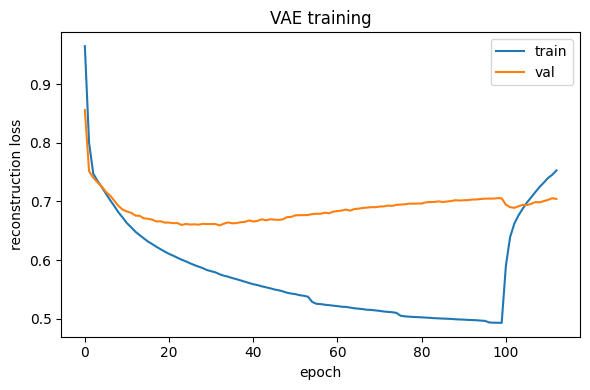

In [4]:
###############################################################################
#                          run experiment                                     #
###############################################################################

# train VAE once
vae_model, vae_hist, vae_stats = train_vae(
    X_full=X,
    latent_dim=LATENT_DIM,
)

print("\nplotting VAE loss")
plt.figure(figsize=(6, 4))
plt.plot(vae_hist["train"], label="train")
plt.plot(vae_hist["val"], label="val")
plt.xlabel("epoch")
plt.ylabel("reconstruction loss")
plt.title("VAE training")
plt.legend()
plt.tight_layout()
plt.show()



In [5]:
# latent components
components = build_latent_components(
    model=vae_model,
    mu_stats=vae_stats["mu"],
    std_stats=vae_stats["std"],
    X=X,
    lb=t_func.lb,
    ub=t_func.ub,
)
latent_dim = components["latent_dim"]
gb_latent  = components["global_bounds"]
latent_obj = components["objective"]

# store histories
hist_native_runs = []
hist_latent_runs = []
hist_sdr_runs    = []

for r in range(N_RUNS):
    seed_r = BASE_SEED_BO + r

    h_native = bo_native_trust(
        dim=DIM_X,
        n_initial=N_INIT_BO,
        n_iter=N_ITER_BO,
        bounds=(-5.0, 5.0),
        n_candidates=N_CAND,
        init_radius=1.0,
        min_radius=0.1,
        seed=seed_r,
    )

    h_latent = bo_latent_trust(
        latent_dim=latent_dim,
        objective=latent_obj,
        global_bounds=gb_latent,
        n_initial=N_INIT_BO,
        n_iter=N_ITER_BO,
        n_candidates=N_CAND,
        init_radius=1.0,
        min_radius=0.1,
        seed=seed_r + 100,
    )

    h_sdr = bo_latent_sdr(
        latent_dim=latent_dim,
        objective=latent_obj,
        global_bounds=gb_latent,
        n_initial=N_INIT_BO,
        n_iter=N_ITER_BO,
        n_candidates=N_CAND,
        seed=seed_r + 200,
        gamma0=0.7,
        gamma_p=1.0,
        eta=0.9,
        min_rel_width=0.02,
        xi_period=5,
    )

    hist_native_runs.append(h_native)
    hist_latent_runs.append(h_latent)
    hist_sdr_runs.append(h_sdr)

hist_native_runs = np.stack(hist_native_runs, axis=0)
hist_latent_runs = np.stack(hist_latent_runs, axis=0)
hist_sdr_runs    = np.stack(hist_sdr_runs, axis=0)

iters = np.arange(N_INIT_BO + N_ITER_BO + 1 - N_INIT_BO)  # histories already length N_ITER_BO+1

def mean_and_band(arr):
    m = arr.mean(axis=0)
    s = arr.std(axis=0)
    return m, m - s, m + s

m_nat, lo_nat, hi_nat = mean_and_band(hist_native_runs)
m_lat, lo_lat, hi_lat = mean_and_band(hist_latent_runs)
m_sdr, lo_sdr, hi_sdr = mean_and_band(hist_sdr_runs)



c:\Users\sg2222\OneDrive - Imperial College London\Documents\Python\Python1\my_venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\sg2222\OneDrive - Imperial College London\Documents\Python\Python1\my_venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\sg2222\OneDrive - Imperial College London\Documents\Python\Python1\my_venv\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 2 of parameter length_scale is close to the specified upper bound 100.0. Increasi

C:\Users\sg2222\AppData\Local\Temp\ipykernel_38388\1667364708.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,10)


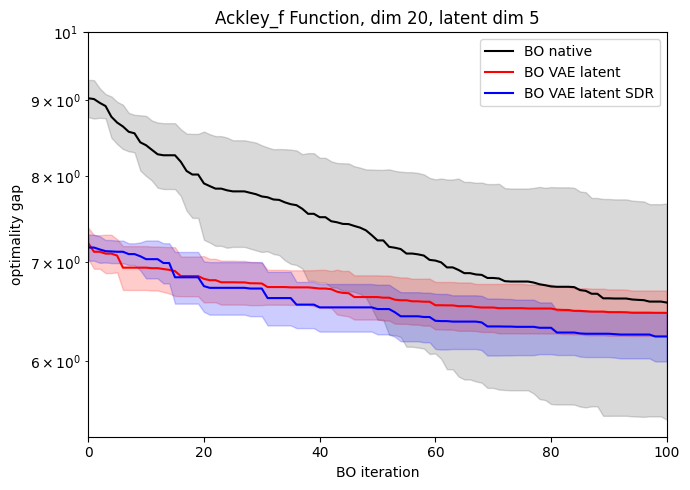

In [10]:
plt.figure(figsize=(7, 5))
plt.semilogy(m_nat, label="BO native",
             color="black")
plt.fill_between(np.arange(len(m_nat)), lo_nat, hi_nat, alpha=0.15, color="black")

plt.semilogy(m_lat, label="BO VAE latent",
             color="red")
plt.fill_between(np.arange(len(m_lat)), lo_lat, hi_lat, alpha=0.2, color="red")

plt.semilogy(m_sdr, label="BO VAE latent SDR",
             color="blue")
plt.fill_between(np.arange(len(m_sdr)), lo_sdr, hi_sdr, alpha=0.2, color="blue")

plt.xlabel("BO iteration")
plt.ylabel("optimality gap")
plt.xlim(0,100)
plt.ylim(0,10)
plt.title(f"{FUNC_NAME} Function, dim {DIM_X}, latent dim {LATENT_DIM}")
plt.legend()
plt.tight_layout()
plt.show()
